In [1]:
%pylab inline

import pandas as pd
import numpy as np
import os
import matplotlib, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from statsmodels.api import OLS

from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from scipy.stats import boxcox, boxcox_normplot

from itertools import product as product

matplotlib.rc('font', family='Verdana')

import statsmodels as sms
import statsmodels.api as sm
from scipy import stats
import pickle
import gc



Populating the interactive namespace from numpy and matplotlib


In [2]:
sms.__version__


'0.8.0rc1'

In [3]:
FREE_MEM = True    # если FREE_MEM = True, для экономии памяти не выводятся никакие графики
#FREE_MEM = False    # если FREE_MEM = False, выводятся все графики


In [4]:
LOAD_MODEL = False # Если LOAD_MODEL = False, рассчитывает модель, у меня занимает ~5 часов 
#LOAD_MODEL = True # Если LOAD_MODEL = True, модель (приложенный бинарнй файл best_model) загружается из файла 


In [5]:
y = pd.read_csv('../data/aggregated_hours_3week_2009.01_2016.06.csv', parse_dates=True, index_col='date')

print('размерность данных',y.shape)
y.head(2)

размерность данных (65711, 102)


,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,40.0,90.0,27.0,39.0,182.0,308.0,333.0,413.0,413.0,184.0,...,4.0,0.0,0.0,46.0,16.0,11.0,0.0,46.0,7.0,6.0
2009-01-01 01:00:00,39.0,108.0,31.0,52.0,225.0,330.0,252.0,355.0,279.0,154.0,...,8.0,0.0,2.0,6.0,18.0,6.0,1.0,23.0,4.0,3.0


In [6]:
# будем исследовать регион 1126
the_reg = '1126'

y_instant = y[the_reg].copy()

In [7]:
# Нормализуем данные
y = y_instant

if not FREE_MEM:
    plt.figure(figsize=(25,5))
    plt.subplot(2,1,1)
    plt.plot(y[:1000])
    plt.title('так выглядят данные - регион '+ the_reg)

    plt.subplot(2,1,2)
    y[:500].plot()
    plt.title('.                                              так выглядят данные ркупным планом - регион '+ the_reg)

In [8]:
# Декомпозиция исходного  ряда
if not FREE_MEM:
    plt.figure(figsize(15,10))
    sm.tsa.seasonal_decompose(x=y[:1000]).plot()
    
    print( "Критерий Дики-Фуллера: p=", sm.tsa.stattools.adfuller(y.iloc[:1000])[1])


Тренд визуально прослеживается, Дики-Фуллер не очень хороший, сезонность четкая, сложная

In [9]:
#регрессионные признаки для учёта сезонностей и трендов
# Признаки регрессии для недели (168) и года (8766)

data = pd.DataFrame(index = y.index)
trend = np.arange(1, len(data)+1)
data['trend'] = trend

K = 5
for i in np.arange(K+1):
    data['week_sin'+str(i)] = np.sin( trend*(2*np.pi*i/168.))
    data['week_cos'+str(i)] = np.cos( trend*(2*np.pi*i/168.))

In [10]:
# Графики регрессоров - синусы и косинусы

if not FREE_MEM:

    print('data.shape', data.shape)

    fig, axes = plt.subplots(ncols=2, nrows=3, sharey=True, figsize=(20,7))

    for ax, yy in zip(np.ravel(axes.T), [data.week_sin2, data.week_sin3, data.week_sin4]):
        ax.plot(trend[:1000], yy[:1000])

    for ax, yy in zip(np.ravel(axes.T)[3:], [data.week_cos2, data.week_cos3, data.week_cos4] ):
        ax.plot(trend[:1000], yy[:1000])

In [11]:
# Делим на обучающую и тестовую выборки

# С января по апрель будем обучать регрессию
train_start_date = pd.to_datetime('2016, 1')
train_end_date = pd.to_datetime('2016, 4, 30 , 23 ')

# Май - будем обучать АРИМУ
may_start = pd.to_datetime('2016, 5, 1, 00')
may_end = pd.to_datetime('2016, 5, 31 , 23 ')

# Июнь - будем использовать для прогноза всей модели (регресссия и АРИМА)
june_start = pd.to_datetime('2016, 6, 1, 00')
june_end = pd.to_datetime('2016, 6, 30 , 23 ')

y_train = y.loc[train_start_date : train_end_date]
y_may  = y.loc[may_start: may_end]
y_may_instant = y_instant.loc[may_start: may_end]
y_june_instant = y_instant.loc[june_start: june_end]


X_train = pd.DataFrame( data.loc[train_start_date : train_end_date] )
X_may = pd.DataFrame( data.loc[may_start: may_end] )
X_june = pd.DataFrame( data.loc[june_start: june_end] )


# размерность данных
print( 'train', y_train.shape  )
print( 'may', y_may.shape  )



train (2904,)
may (744,)


In [12]:
# Регрессоры - недельная сезонность
X_train.head(1)

,trend,week_sin0,week_cos0,week_sin1,week_cos1,week_sin2,week_cos2,week_sin3,week_cos3,week_sin4,week_cos4,week_sin5,week_cos5
date,,,,,,,,,,,,,
2016-01-01,61345,0.0,1.0,0.804598,0.59382,0.955573,-0.294755,0.330279,-0.943883,-0.56332,-0.826239,-0.999301,-0.037391


### Обучение регрессии и анализ остатков

In [13]:
# Обучаем регрессию
ols = OLS(exog=sm.add_constant(X_train), endog=y_train).fit_regularized(L1_wt = 0, alpha=1)

средняя остатков регрессии residuals.mean() =  -2.4916681771047284


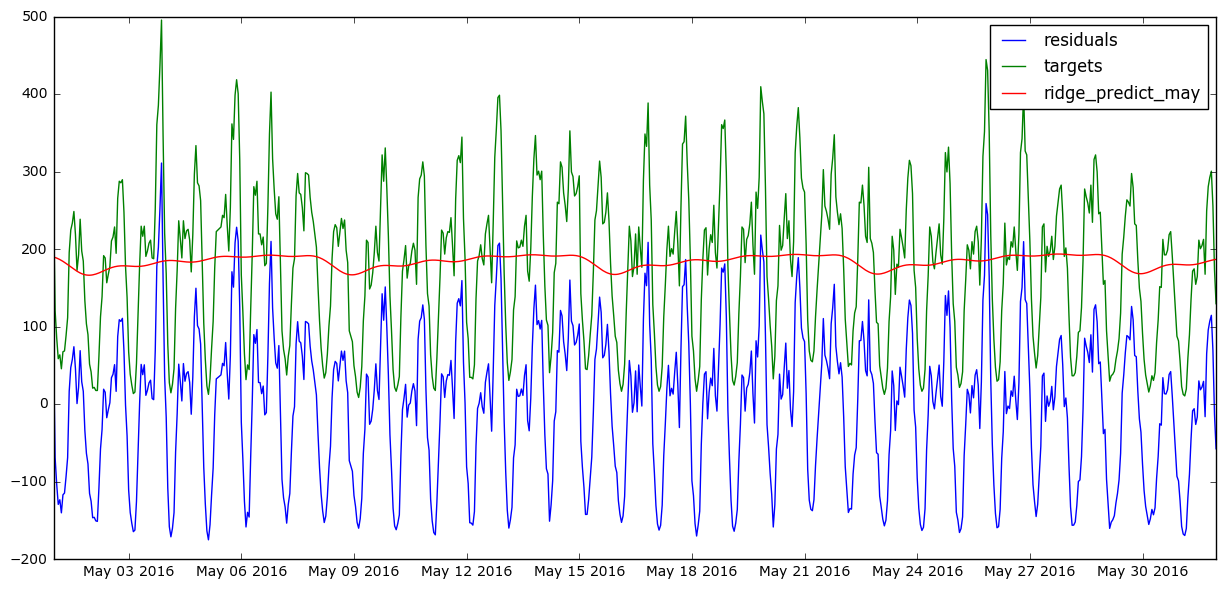

In [14]:
ols_predict_may = pd.Series(data=np.ravel( ols.predict(exog=sm.add_constant(X_may))), index=X_may.index )
ols_predict_june = pd.Series(data=np.ravel( ols.predict(exog=sm.add_constant(X_june))), index=X_june.index )

residuals = y_may - ols_predict_may
ols_resid_mean = residuals.mean()
print('средняя остатков регрессии residuals.mean() = ', ols_resid_mean)

plt.figure(figsize(15,7))
plt.plot(residuals, label='residuals')
plt.plot(y_may, label = 'targets')
plt.plot(ols_predict_may, label = 'ridge_predict_may')
plt.legend()

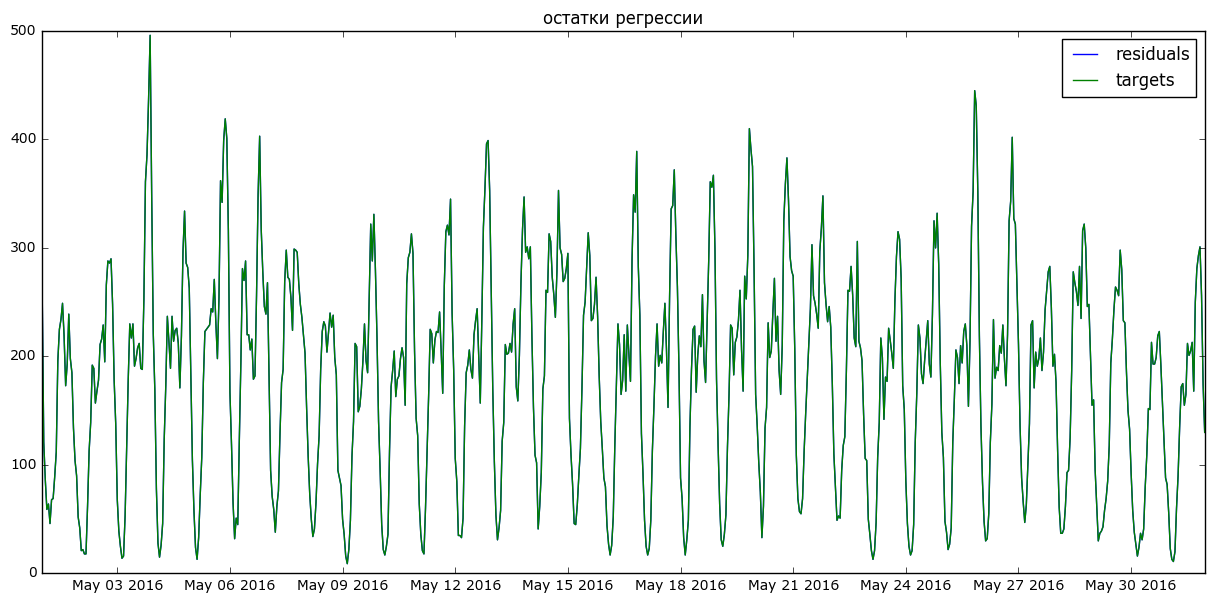

In [15]:
plt.figure(figsize(15,7))
plt.plot(residuals+ols_predict_may, label='residuals')
plt.plot(y_may, label = 'targets')
plt.title('остатки регрессии')
plt.legend()

### Преобразование Бокса-Кокса для остатков регрессии

In [16]:
# BoxCox_shift - параметр, который будет использоваться в обратном преобразовании
BoxCox_shift = 2 + abs(np.min(residuals) )

BoxCox = residuals + BoxCox_shift     # поднимаем ряд остатков регрессии над нулём
del(residuals)
BoxCox = boxcox( x=BoxCox, alpha=0.05 )  # boxcox_lambda понадобится для обратного пеобразования

BoxCox_resid = pd.Series(data=BoxCox[0], index=y_may.index)


BoxCox lambda = 0.773252462354
Критерий Дики-Фуллера: p = 0.000346680749138


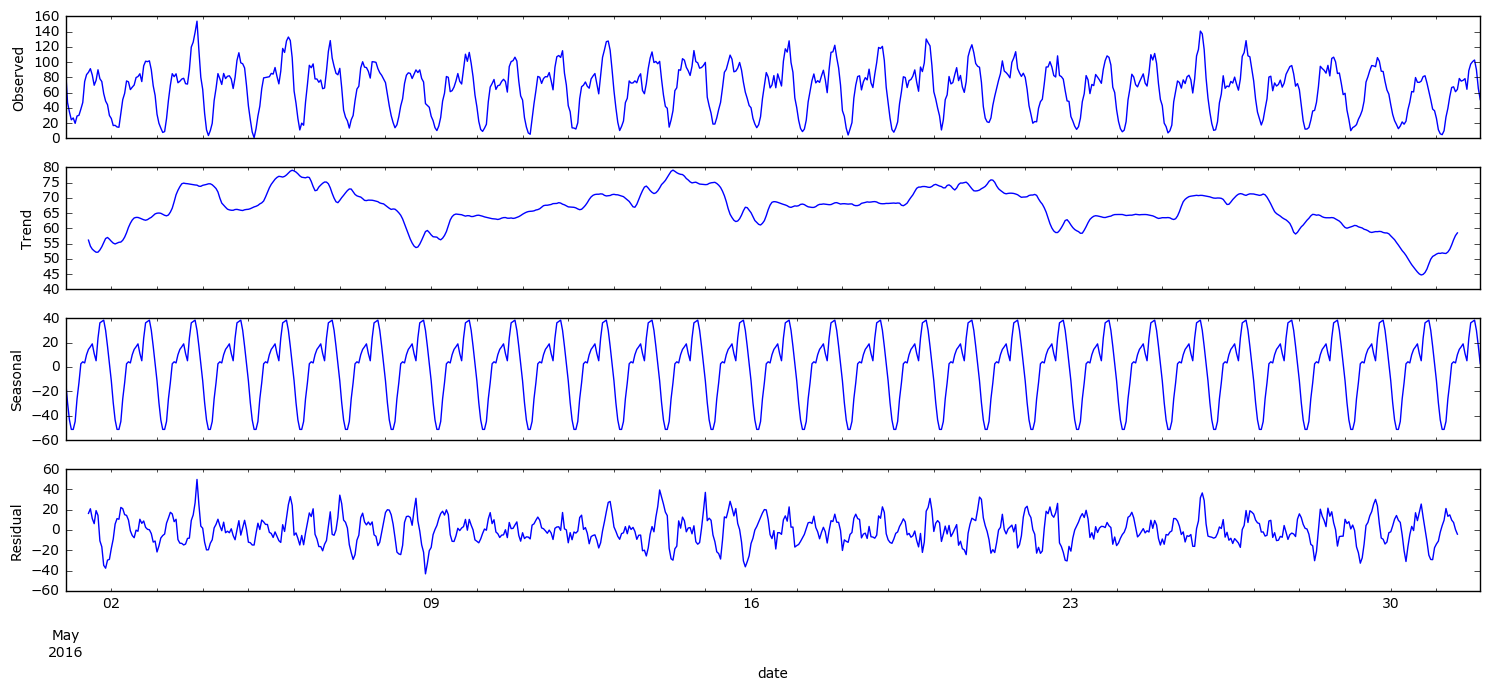

In [17]:
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(BoxCox_resid[:1000]).plot()
print('BoxCox lambda =', BoxCox[1])
print( "Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(BoxCox_resid)[1])



Тренд прослеживается, сезонность сложная, Дики-Фуллер так себе, остатки не выглядят хаотично.

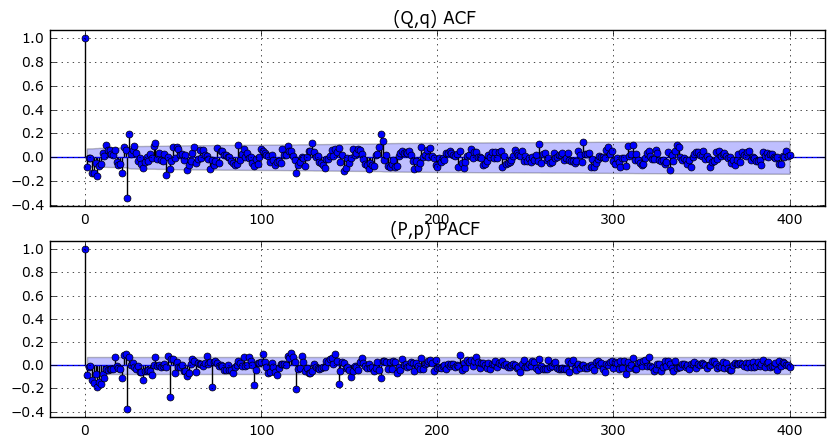

In [18]:
# Сезонное дифференцирование
shiftS = 24
residualsS = (BoxCox_resid - BoxCox_resid.shift(shiftS))[shiftS:]

# Дифференцирование на единичный лаг
shift1 = 1
residualsSminus1 = (residualsS - residualsS.shift(shift1))[shift1:]


acf_shift = shiftS+shift1

plt.figure(figsize=(10,5))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(residualsSminus1[acf_shift:], lags = 400, ax=ax, title='(Q,q) ACF ')
plt.grid()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(residualsSminus1[acf_shift:], lags = 400, ax=ax, title='(P,p) PACF ')
plt.grid()


После второго дифференцирования визуально ряд выглядит стационарно, Дики-Фуллер уверенно отвергает нестационарность

на больших лагах автокорреляций нет, подбираем параметры АРИМы

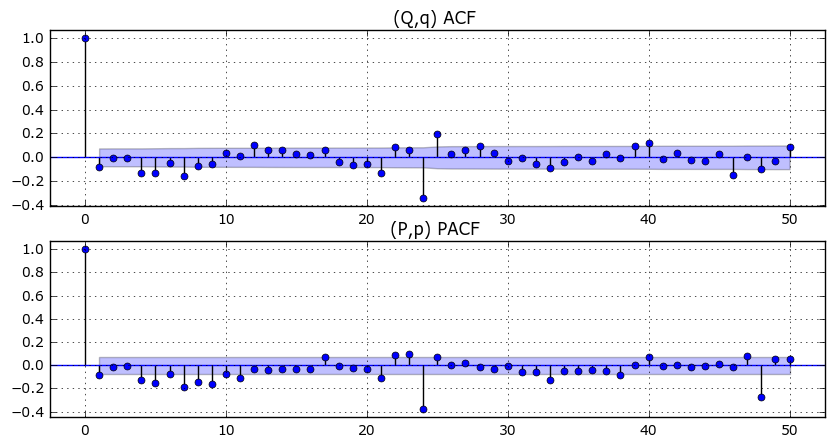

In [19]:
plt.figure(figsize=(10,5))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(residualsSminus1[acf_shift:], lags = 50, ax=ax, title='(Q,q) ACF ')
plt.grid()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(residualsSminus1[acf_shift:], lags = 50, ax=ax, title='(P,p) PACF ')
plt.grid()


In [20]:
ps=[1,9]
ds=[1]
qs=[1]
Ps=[1,4,6]
Ds=[1]
Qs=[1,2]


parameters_list = list(product(ps, ds, qs, Ps, Ds, Qs) )
print( len(parameters_list), 'наборов параметров') 

12 наборов параметров


In [21]:
# Функция сохранения в файл модели - чтобы каждый раз не пересчитывать
def save_model(fname, *model):
    with open(fname,"wb") as fout:
        pickle.dump(model, fout)

In [22]:
%%time
path = '3week_copy3_models/'
results = []

if LOAD_MODEL == False:
    import warnings
    warnings.filterwarnings('ignore')
    
    for file in os.scandir(path):
        os.remove(file.path)
    # Вычисление модели АРИМА - у меня занимает ~5 часов
    exog_arima = trend[:len(BoxCox_resid)]
    for i, param in enumerate(parameters_list):

        print(i)
        try:
            sarimax=sms.tsa.statespace.sarimax.SARIMAX(BoxCox_resid, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], 24)).fit(disp=-1)
        except ValueError:
            print(i, 'wrong parameters:', param)
            continue
        except LinAlgError: 
            #print('LinAlgError:', param)
            continue
        else:
            file_name = path+'model'+str(i)
            #print(i, file_name)
            save_model(file_name, [param, sarimax.aic, sarimax])

            print( i, '...', param)
            #results.append([param, sarimax.aic, sarimax])
    warnings.filterwarnings('default')
            

0
0 ... (1, 1, 1, 1, 1, 1)
1
1 ... (1, 1, 1, 1, 1, 2)
2
2 ... (1, 1, 1, 4, 1, 1)
3
3 ... (1, 1, 1, 4, 1, 2)
4
4 ... (1, 1, 1, 6, 1, 1)
5
5 ... (1, 1, 1, 6, 1, 2)
6
6 ... (9, 1, 1, 1, 1, 1)
7
7 ... (9, 1, 1, 1, 1, 2)
8
8 ... (9, 1, 1, 4, 1, 1)
9
9 ... (9, 1, 1, 4, 1, 2)
10
10 ... (9, 1, 1, 6, 1, 1)
11
11 ... (9, 1, 1, 6, 1, 2)
Wall time: 1h 30min 33s


In [23]:
%%time
# Загружаем АРИМу
result_table = pd.DataFrame()

for fname in os.scandir(path):
    file = open(fname.path, 'rb')
    ser = pd.Series(*pickle.load(file) )#, index= ['params', 'AIC', 'model'])
    result_table=result_table.append(ser, ignore_index=True)
    file.close()

result_table.columns = ['params', 'AIC', 'model']
result_table.sort_values(by='AIC', ascending=True, inplace=True)
result_table.index = np.arange(len(result_table))

best_model = result_table.model.iloc[0]


Wall time: 50.3 s


In [24]:
result_table.head(20)

,params,AIC,model
0,"(9, 1, 1, 6, 1, 1)",5075.372792,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,"(9, 1, 1, 6, 1, 2)",5076.926318,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,"(1, 1, 1, 6, 1, 1)",5085.470873,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,"(1, 1, 1, 6, 1, 2)",5092.925319,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,"(9, 1, 1, 4, 1, 2)",5140.698221,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,"(9, 1, 1, 4, 1, 1)",5146.056059,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,"(1, 1, 1, 4, 1, 1)",5181.107760,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,"(9, 1, 1, 1, 1, 2)",5187.528902,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,"(9, 1, 1, 1, 1, 1)",5188.127442,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,"(1, 1, 1, 4, 1, 2)",5256.965828,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [25]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  744
Model:             SARIMAX(9, 1, 1)x(6, 1, 1, 24)   Log Likelihood               -2519.686
Date:                            Wed, 03 May 2017   AIC                           5075.373
Time:                                    03:22:34   BIC                           5158.390
Sample:                                05-01-2016   HQIC                          5107.373
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2252      0.142      1.590      0.112      -0.052       0.503
ar.L2          0.0179      0.059      0.306      0.760      -0.097       0.133
ar.L3         -0.0941      0.041     -2.307      0.021      -0.174      -0.014
ar.L4         -0.1512      0.043     -3.499      0.000      -0.236      -0.066
ar.L5         -0.1420      0.047     -3.037      0.002      -0.234      -0.050
ar.L6         -0.0226      0.048     -0.472      0.637      -0.117       0.071
ar.L7         -0.1922      0.040     -4.750      0.000      -0.271      -0.113
ar.L8         -0.0548      0.058     -0.951      0.341      -0.168       0.058
ar.L9         -0.1146      0.052     -2.209      0.027      -0.216      -0.013
ma.L1         -0.5512      0.138     -3.980      0.000      -0.823      -0.280
ar.S.L24      -0.5625      0.063     -8.915      0.000      -0.686      -0.439
ar.S.L48      -0.5965      0.048    -12.522      0.000      -0.690      -0.503
ar.S.L72      -0.5613      0.051    -11.069      0.000      -0.661      -0.462
ar.S.L96      -0.5866      0.043    -13.789      0.000      -0.670      -0.503
ar.S.L120     -0.6044      0.041    -14.870      0.000      -0.684      -0.525
ar.S.L144     -0.3455      0.046     -7.446      0.000      -0.436      -0.255
ma.S.L24      -0.3808      0.073     -5.214      0.000      -0.524      -0.238
sigma2        57.7655      2.914     19.822      0.000      52.054      63.477
===================================================================================
Ljung-Box (Q):                       37.93   Jarque-Bera (JB):                13.27
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.16
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Посмотрим на остатки АРИМЫ

best_model.resid.mean() 0.25258412463393576
Критерий Стьюдента: p=0.356554
Критерий Дики-Фуллера: p=0.000000


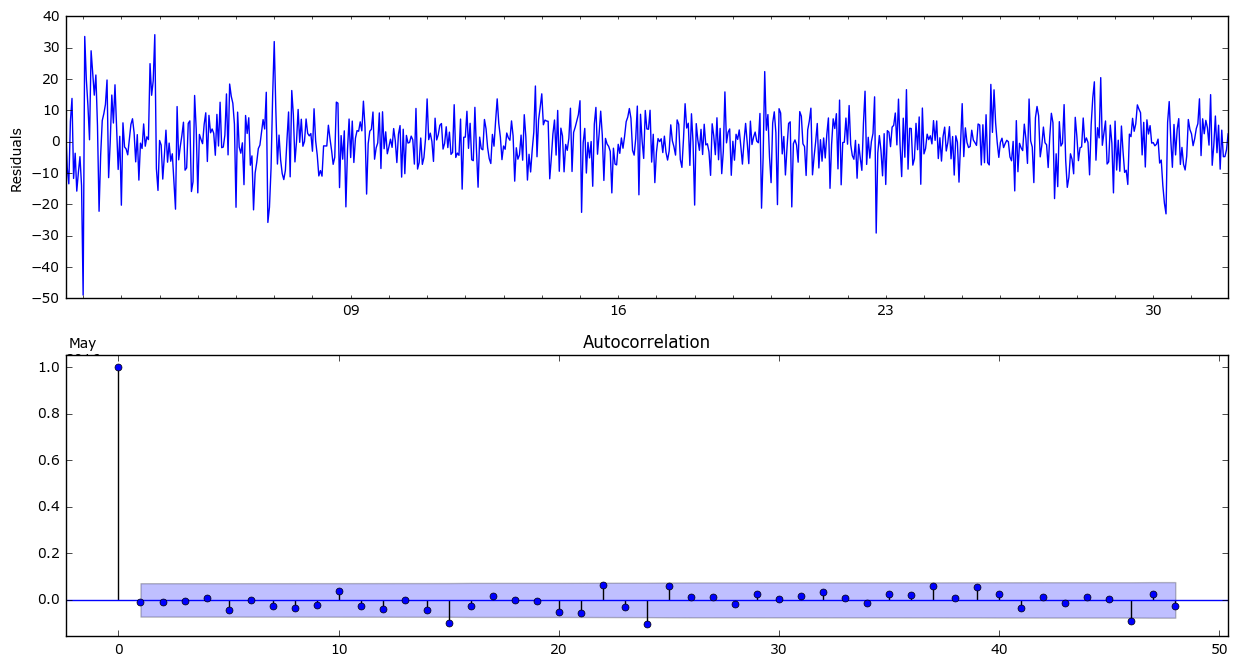

In [26]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print('best_model.resid.mean()', best_model.resid.mean())
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

Арифметическая средняя остатков практически равна нулю, критерий Стьюдента это не отвергает. 
Дики-Фуллер хороший, визуально остатки похожи на шум
Коррелограмма выглядит хорошо, критерий Льюнга-Бокса не отверает неавтокоррелированность остатков АРИМы

In [27]:
# Обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

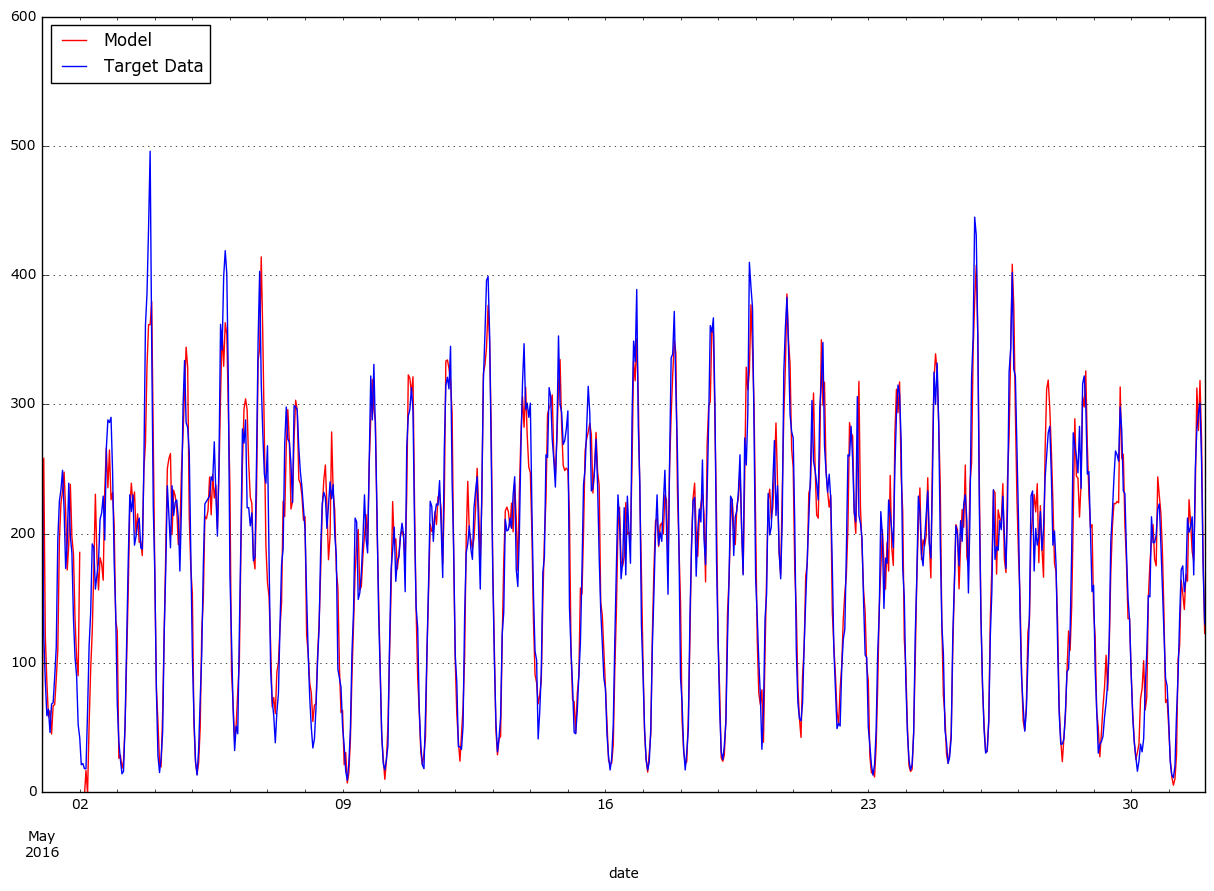

fitted_resid.mean() =  0.8332944335771496
Критерий Стьюдента: p=0.356554
Критерий Дики-Фуллера: p=0.000000


In [28]:
plt.figure(figsize(15,10))

arima_may = pd.Series(index=y_may.index, 
    data = invboxcox(y=best_model.fittedvalues, lmbda=BoxCox[1] )
                    + ols_predict_may 
                    - BoxCox_shift )

arima_may.plot(color='r', label='Model')
y_may_instant.plot(grid=True, label='Target Data')

plt.legend(loc=2)
plt.ylim(0,600)
plt.show()

fitted_resid = y_may_instant - arima_may
print('fitted_resid.mean() = ', fitted_resid.mean())
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])


## Построение прогноза

In [29]:
def forecast(model, boxcox=BoxCox[1], instant_label=y_june_instant,
             ols_predict=ols_predict_june):

    horizon=instant_label.shape[0]
    index=instant_label.index 
    
    future = pd.DataFrame(index=index)
    
    future['regr_june'] = ols_predict

    f = model.predict(start=best_model.fittedvalues.shape[0], 
                           end=best_model.fittedvalues.shape[0]+horizon-1 )

    print(len(f))
    future['model'] = invboxcox(y=f, lmbda=boxcox) \
        + ols_predict \
        - BoxCox_shift \
        - ols_resid_mean



    #future_model = invboxcox( best_model.predict(start=283, end=284+35), BoxCox[1] )
    return future

719


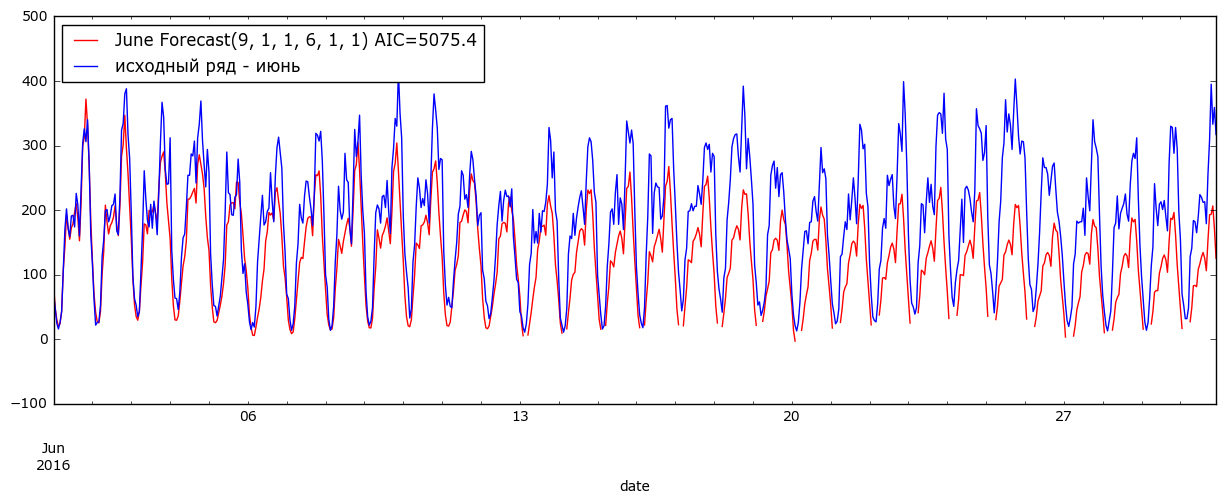

От тренда избавится не удалось, прогноз уменьшает верхние значения каждого дня
Остатки растут, есть тренд, избавится него не удалось


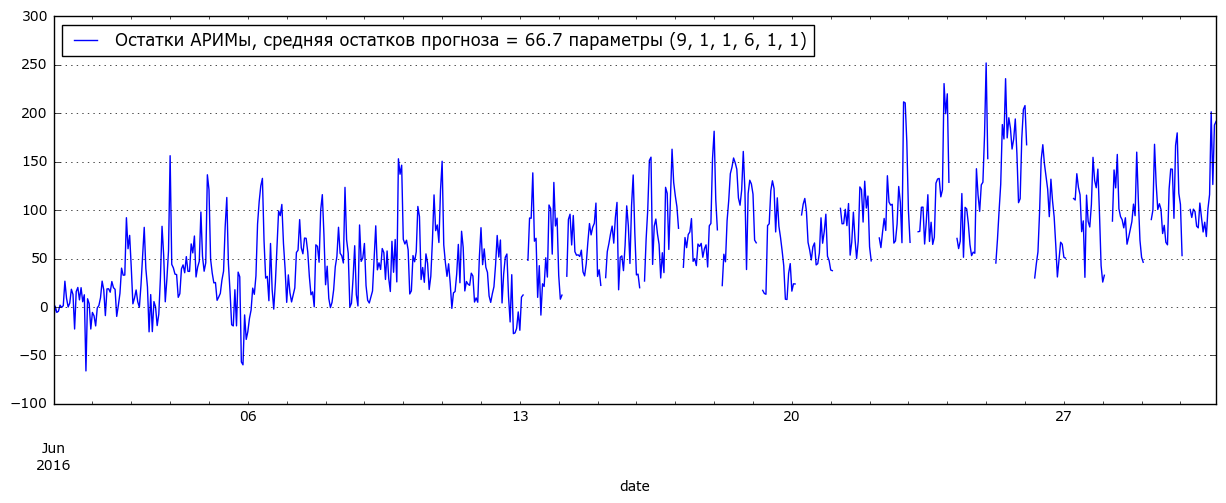

In [30]:
plt.figure(figsize(15,5))

bm_row = result_table.iloc[0]
best_model_june = forecast(bm_row.model, BoxCox[1])

bm_residuals_june = y_june_instant - best_model_june.model

plt.figure(figsize(15,5))
best_model_june.model.plot(label='June Forecast'+str(bm_row.params)+' AIC='+ str(round(bm_row.AIC,1)), color='r')
y_june_instant.plot(label='исходный ряд - июнь')
plt.legend(loc=2)
plt.show()
print('От тренда избавится не удалось, прогноз уменьшает верхние значения каждого дня')

plt.figure(figsize(15,5))    
bm_residuals_june.plot(grid=True, label='Остатки АРИМы, средняя остатков прогноза = '+str(round(bm_residuals_june.mean(), 1 ))
                       +' параметры '+str(bm_row.params))
plt.legend(loc=2)
print('Остатки растут, есть тренд, избавится него не удалось')


In [31]:
import subprocess
subprocess.call(["shutdown", "/s"])

0